In [1]:
import numpy as np
import sys, os, ROOT

Welcome to JupyROOT 6.24/06


In [2]:
loadParts=True
ifplot=False
engplot=False
import matplotlib.pyplot as plt

In [3]:
def numLines(beamFile):
    import csv
    with open(beamFile+".csv") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        N = 0
        for row in csv_reader:
            N += 1
        csv_file.close()
    from datetime import datetime
    dt = datetime.now()
    print("There are ",N,"lines"+dt.strftime("%H-%M-%S"))
    return N

In [4]:
def converter(hIn):
    xax = np.zeros(hIn.GetXaxis().GetNbins()+1)
    for i in range(len(xax)-1):
        xax[i] = hIn.GetXaxis().GetBinLowEdge(i+1)
    xax[-1] = hIn.GetXaxis().GetBinUpEdge(hIn.GetXaxis().GetNbins())
    
    yax = np.zeros(hIn.GetYaxis().GetNbins()+1)
    for i in range(len(yax)-1):
        yax[i] = hIn.GetYaxis().GetBinLowEdge(i+1)
    yax[-1] = hIn.GetYaxis().GetBinUpEdge(hIn.GetYaxis().GetNbins())
    
    #print(xax)
    #print(yax)
    
    hOut = np.zeros( (len(yax),len(xax)) )
    #print (hOut)

    for xi in range(hIn.GetXaxis().GetNbins()):
        for yi in range(hIn.GetYaxis().GetNbins()):
            bx = hIn.GetBin(xi+1,yi+1)
            hOut[yi,xi] = hIn.GetBinContent(bx)
    
    #print(hOut)
    plt.imshow(hOut,origin='lower')
    
    return (hOut,xax,yax)

In [5]:

Twiss = [0.11315,1006.80,-60.44,0.12155,129.72,-7.72]
thick = 0
energy=570
Engcut = 95.0
material=["G4_Al"]
beam="proton"
beamAngle=0
N=1e5
zoff = "*-50"
file =  "PBW_570MeV_beta1007,130m_RMamp0,0mm_N1.4e+07_NpB500_NPls1e+03"
PBIP = False #slows down, only use when needed
picPWD = "/uio/hume/student-u52/ericdf/Documents/UiO/Forske/ESSProjects/PBWScattering/Pictures/"
csvPWD = "/scratch2/ericdf/PBWScatter/CSVs/" #put all CSVs in Scratch to save my disk space!
beamFile = csvPWD + file
if not os.path.isfile(beamFile+".csv"):
    raise Exception("CSV not found!")
physList ="QGSP_BERT_EMZ" # "QGSP_BERT_EMZ" or "FTFP_BERT_EMZ"
options  = {'noText':False, 'noBox':False, 'wide':True, 'physList':physList, 'dependence':"Twiss",
                            'xlim':450, 'ylim':500, 'maxim':0, 'saveHist':False,
                            'PBIP':False, 'beamClass':"ESS", 'Nb':10, 'failure':0,
                            'magFails':2, 'saveRaster':False }
envXAngle = 0
envYAngle = 0
beamXAngle = envXAngle
beamYAngle = envYAngle

In [6]:
#constants for below use
QUIET     = False #Reduced output, doesn't show events
saveParts = False

#particle characteristic values
if beam == "proton":
    partA = 938.27209 #[MeV/c2]
    partZ = 1
elif beam == "electron":
    partA = 0.511 #[MeV/c2]
    partZ = 1
c = 2.99792e8 #[m/s]
MeV = 1e6*1.602e-19 
um = 1e-6 #[m] #need to convert to real units as the equations use real units.
m = 1 #[m]
mm = 1e-3 #[m]
ummrad = um*1e-3
gamma_rel = 1 + energy/partA #from PrintTwissParameters
beta_rel = np.sqrt(gamma_rel*gamma_rel -1 )/gamma_rel

#Setup MiniScatter -- modify the path to where you built MiniScatter!
MiniScatter_path="../../MiniScatter/build/."
sys.path.append(MiniScatter_path) #uncomment this if this is your first time running this.
#print(os.getcwd())
if os.uname()[1] == "tensor.uio.no":
    if os.getcwd() != "/uio/hume/student-u52/ericdf/Documents/UiO/Forske/ESSProjects/PBWScattering/MiniScatter/build/":
        os.chdir("/uio/hume/student-u52/ericdf/Documents/UiO/Forske/ESSProjects/PBWScattering/MiniScatter/build/")
elif os.uname()[1] == "mbarrios-XPS-13-9300":
    if os.getcwd() != "/home/efackelman/Documents/UiO/Forske/ESSProjects/PBWScattering/MiniScatter/build/":
        os.chdir("/home/efackelman/Documents/UiO/Forske/ESSProjects/PBWScattering/MiniScatter/build/")
else: print("Help! Unknown build directory!, simulation.py l 50")
#print(os.getcwd())

import miniScatterDriver
#import miniScatterScanner
#import miniScatterPlots

### Basic simulation parameters ###
TRYLOAD = True  #Try to load already existing data instead of recomputing, only if using getData_TryLoad function.
NUM_THREADS = 8 #Number of parallel threads to use for scans
#Where to store temporary data for scans (a fast file system, NOT EOS/AFS)
TMPFOLDER = "/tmp/miniScatter/SimpleDemo_thicknessScan"

#When making multiple scans, it's nice to first create a `baseSimSetup` and then modify it for each simulation
# Note: each argument here corresponds roughly to a command line argument.
# Look inside miniScatterDriver.runScatter() to see how.

baseSimSetup = {}
#baseSimSetup["PHYS"] = "QGSP_BERT__SS" #Use the __SS physics lists for thin foils due to checking each atom cross section
baseSimSetup["PHYS"]  = options['physList'] #better for scattering through 1mm sheets

#Particle Beam definitions
#baseSimSetup["BEAM_RCUT"] = 3.0
#Where to start the beam [mm]
#baseSimSetup["ZOFFSET_BACKTRACK"] = True
baseSimSetup["N"]         = N #need N regardless of beam origin
baseSimSetup["ZOFFSET"]   = zoff

#Use a distribution defined by Twiss parameters for ESS beam ~where PBW is
# 3 variables = symmetric, 6 variables = asymetric
EPSX   = Twiss[0] #[um]
BETAX  = Twiss[1] #[m]
ALPHAX = Twiss[2] #[mm-mrad]
EPSY   = Twiss[3] #[um]
BETAY  = Twiss[4] #[m]
ALPHAY = Twiss[5] #[mm-mrad]

#For loading particles
if loadParts == True:
    #picPWD = "/uio/hume/student-u52/ericdf/Documents/UiO/Forske/ESSProjects/PBWScattering/Pictures/"
    #beamFile = "PBW_570MeV_eX113um,eY122um_bX941m,bY120m_aX-59mm,aY-7mm_N1.4e+05_2.9e+02us_cyrille"
    #from plotFit import numLines
    parts = numLines(beamFile)
    baseSimSetup["N"]        = parts #change to match file particles. Used for file name
    baseSimSetup["BEAMFILE"] = beamFile+".csv" # number of particles >= N
    baseSimSetup["ENERGY"]   = energy #570 #[MeV] #ESS beam energy update 15.8
else:
    baseSimSetup["BEAM"]    = beam
    baseSimSetup["ENERGY"] = energy #570 #[MeV] #ESS beam energy update 15.8
    baseSimSetup["COVAR"] = (EPSX,BETAX,ALPHAX,EPSY,BETAY,ALPHAY) #only for without "--beamFile"

#Get rid of Normalized Emittance!
Igemtx = EPSX/(beta_rel*gamma_rel)
Igemty = EPSY/(beta_rel*gamma_rel)

#Beam particle type
Rcut = 1000.0
Engcut = 0.9
baseSimSetup["WORLDSIZE"] = Rcut #[mm] Make the world wider for seeing where particles go
baseSimSetup["POSLIM"] = Rcut #XY histogram Position Limit for a few, check RootFileWriter.cc
#Beam Angle
#Defined by the beam size at BPM94 (TBD) compared to size at BPM93 (~0)
if beamXAngle != 0 or beamYAngle != 0:
    dBPM93to94 = 3031 #[mm]
    #beamAngle = np.arctan(sizeAtBPM94/dBPM93to94) #rad?
    modXThick = thick / np.cos(beamXAngle) 
    modYThick = thick / np.sin(beamYAngle)
    print(beamXAngle,modXThick,beamYAngle,modYThick)
#Some more output settings
baseSimSetup["QUICKMODE"] = False #Include slow plots
baseSimSetup["MINIROOT"]  = False #Skip TTRees in the .root files
baseSimSetup["ANASCATTER"] = True #don't do Analytical Scatter Angle Test
baseSimSetup["EDEP_DZ"]   = 1.0 #Z bin width for energy deposit histogram
baseSimSetup["CUTOFF_RADIUS"] = Rcut #[mm]Larger radial cutoff #Decreased 10 May
baseSimSetup["CUTOFF_ENERGYFRACTION"] = Engcut #Minimum percent of full Energy to use in cutoff calculations
#print(baseSimSetup)

#Define material nickname
#radiation lengths are from https://pdg.lbl.gov/2019/AtomicNuclearProperties/
if material == "G4_Galactic":
    mat = "Vac"
    radLen = 1e24 #[mm] basically infinity
    atomZ = 0.1
    atomA = 0.1
elif material == "G4_Al":
    mat = "Al"
    radLen = 88.97 #[mm]
    atomZ = 13
    atomA = 26.981
elif material == "G4_AIR":
    mat = "Air"
    radLen = 3.122e5 #[mm] -taken from 80% N2 gas(3.260e5mm) and 20% O2 gas (2.571e5mm)
    atomZ = 2 #the lbl page says Z/A = 0.49919, so 2/4 is close enough
    atomA = 4
elif material == "G4_Au":
    mat = "Au"
    radLen = 3.344
    atomZ = 79
    atomA = 196.966

if thick!=0.0:
    baseSimSetup["THICK"] = thick
    baseSimSetup["MAT"] = material
    #Valid choices: G4_Al, G4_Au, G4_C, G4_Cu, G4_Pb, G4_Ti, G4_Si, G4_W, G4_U, G4_Fe, G4_MYLAR, G4_KAPTON,
    #G4_STAINLESS-STEEL, G4_WATER,G4_SODIUM_IODIDE, G4_Galactic, G4_AIR, Sapphire, ChromoxPure, ChromoxScreen

    #Detector distance from target center [mm] Default is 50mm behind Target
    #For multiple detector locations, make a list, e.g. [-5,5,5000] but they stack in TTree.
    baseSimSetup["DIST"] = [4400] #Detector location. only at ESS Target location
    if loadParts:
        import re
        name = re.sub(".+(PBW)",mat,beamFile)
        #print(name)
        outname = name + "_run"
    else:
        outname = "simplePBW_"+str(baseSimSetup["THICK"])+"mm"+mat+"_{:.0f}MeV_emtx{:.0f}um".format(baseSimSetup["ENERGY"],Twiss[1]*1e3)

else:
    baseSimSetup["THICK"] = 0.0
    baseSimSetup["DIST"] = [4400] #Detector locations. At ESS Target location 
    baseSimSetup["MAGNET"] = []
    #How to construct a magnet for miniScatterDriver, as per kyrsjo/MiniScatter/blob/master/examples/SiRi DeltaE-E detector.ipynb
    #Specialized PBW magnet!
    m1 = {}
    m1["pos"]      = 24.125 #[mm] Minimum position is 24.125mm for r=88m,t=4.25,arcPhi=120!!
    m1["type"]     = "PBW"
    m1["length"]   = 0 #[mm] Must be 0!
    m1["gradient"] = 0.0
    m1["keyval"] = {}
    m1["keyval"]["material"]   = material
    m1["keyval"]["radius"]     = 88.0 #[mm]
    m1["keyval"]["al1Thick"]   = 1.0 #[mm]
    m1["keyval"]["waterThick"] = 2.0 #[mm]
    m1["keyval"]["al2Thick"]   = 1.25 #[mm]
    baseSimSetup["MAGNET"].append(m1)

    m1Len = baseSimSetup["MAGNET"][0]["keyval"]["al1Thick"]
    m3Len = baseSimSetup["MAGNET"][0]["keyval"]["al2Thick"]
    mat = "Real"
    radLenAl = 88.97 #[mm] Al
    radLenH2O = 360.8 #[mm] liquid Water 
    #from https://cds.cern.ch/record/1279627/files/PH-EP-Tech-Note-2010-013.pdf

    if loadParts:
        #outname = "PBW_{:.0f}MeV_eX{:.0f}um,eY{:.0f}um_bX{:.0f}m,bY{:.0f}m_aX{:.0f},aY{:.0f}_N{:.0e}_mult16".format(baseSimSetup["ENERGY"],EPSX*1e3,EPSY*1e3,BETAX,BETAY,ALPHAX,ALPHAY,baseSimSetup["N"])
        outname = beamFile+"_runW"
    else:
        outname = "PBW_{:.0f}MeV_eX{:.0f}um,eY{:.0f}um_bX{:.0f}m,bY{:.0f}m_aX{:.0f},aY{:.0f}_t{:.0f}mm_N{:.0e}".format(baseSimSetup["ENERGY"],EPSX*1e3,EPSY*1e3,BETAX,BETAY,ALPHAX,ALPHAY,thick,baseSimSetup["N"])
        #outname = "PBW_{:.0f}MeV_eX{:.0f}_N{:.0e}_{:.0f}mmRcut".format(baseSimSetup["ENERGY"],EPSX*1e3,baseSimSetup["N"],Rcut)
        #outname = "PBW_{:.0f}MeV_eX{:.0f}_N{:.0e}_{:.2f}mmAl1{:.2f}mmAl2".format(baseSimSetup["ENERGY"],EPSX*1e3,baseSimSetup["N"],m1Len,m3Len)
        #outname = "PBW_{:.0f}MeV_ESS".format(baseSimSetup["ENERGY"])

    if options['PBIP']:
        outname = outname + "_PBIP"
        #PBIP Magnet
        m2 = {}
        m2["pos"] = 1874.0 #[mm]
        m2["type"] = "COLLIMATORRECT"
        m2["length"]   = 450.0 #[mm]
        m2["gradient"] = 0.0
        m2["keyval"] = {}
        m2["keyval"]["material"] = "G4_Al"
        m2["keyval"]["holeWidth"]   = 200.0 #[mm]
        m2["keyval"]["holeHeight"]   = 80.0 #[mm]
        m2["keyval"]["absorberWidth"]    = 950.0 #[mm]
        m2["keyval"]["absorberHeight"]   = 950.0 #[mm]
        baseSimSetup["MAGNET"].append(m2)

if options['physList'] == "QGSP_BERT_EMZ":
    outname = outname + "_QBZ"
elif options['physList'] == "FTFP_BERT_EMZ":
    outname = outname + "_FBZ"

#Store the .root files in a subfolder from where this script is running,
# normally MiniScatter/examples, in order to keep things together

#Remove upper directories that may have come with beamFile for appending outname to scratch folder
import re
if re.search("/PBW_",outname):
    #print("\n",outname,"\n")
    outname = re.sub(".+(?=(PBW_))","",outname)
    #print("removed",outname)

#Find which folder root file is in
if os.uname()[1] == "mbarrios-XPS-13-9300":
    baseSimSetup["OUTFOLDER"] = os.path.join("/home/efackelman/Documents/UiO/Forske/ESSProjects/PBWScattering/scatterPBWFiles/")
elif os.uname()[1] == "tensor.uio.no":
    if Twiss[1] >= 1:
        baseSimSetup["OUTFOLDER"] = os.path.join("/scratch2/ericdf/PBWScatter/ESS/")
    elif Twiss[1] < 1:
        baseSimSetup["OUTFOLDER"] = os.path.join("/scratch2/ericdf/PBWScatter/pencil/")
    else:
        baseSimSetup["OUTFOLDER"] = os.path.join("/scratch2/ericdf/PBWScatter/")
else: print("Help! Unknown build directory!, simulation.py l 243")

#print(baseSimSetup["OUTFOLDER"])
#put in Scratch2 of tensor for faster processing, as per Kyrre

#copy so it is if running multiple scans in a Jupyter notebook
simSetup_simple1 = baseSimSetup.copy()

#print(outname,"\n")
simSetup_simple1["OUTNAME"] = outname #"PBW_570MeV_pencil_N1e+05"#

####Redundant??? ----------
#Variables for automation
if os.uname()[1] == "mbarrios-XPS-13-9300":
    savepath = "/home/efackelman/Documents/UiO/Forske/ESSProjects/PBWScattering/scatterPBWFiles/"
elif os.uname()[1] == "tensor.uio.no":
    #savepath = "/scratch2/ericdf/PBWScatter/"
    savepath = "/uio/hume/student-u52/ericdf/Documents/UiO/Forske/ESSProjects/PBWScattering/Pictures/" #Eric's files location
savename=savepath+outname #base savename for plots downstream, brings directly to my directory
savedfile=os.path.join(simSetup_simple1["OUTFOLDER"],simSetup_simple1["OUTNAME"])+".root"

#print(simSetup_simple1)

There are  14385000 lines11-55-23


In [7]:
(twiss_PBW, numPart_PBW, objects_PBW) = \
    miniScatterDriver.getData_tryLoad(simSetup_simple1, tryload=TRYLOAD,getObjects=["tracker_cutoff_xy_PDG2212"])

Found a file at '/scratch2/ericdf/PBWScatter/ESS/PBW_570MeV_beta1007,130m_RMamp0,0mm_N1.4e+07_NpB500_NPls1e+03_runW_QBZ.root', loading!


In [8]:
#cc1 = ROOT.TCanvas()
targ=objects_PBW["tracker_cutoff_xy_PDG2212"]
#targ.Draw()
#cc1.Draw()

In [9]:
print("Y Axis")

Y Axis


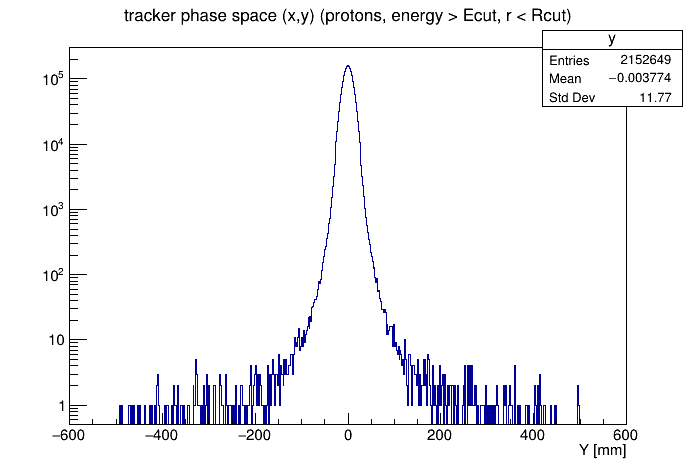

In [30]:
#targY = targ.Clone()
projY = targ.ProjectionY("y",targ.GetYaxis().FindBin(-2),targ.GetYaxis().FindBin(2))
cc1 = ROOT.TCanvas()
projY.Draw()
projY.GetXaxis().SetRangeUser(-600,600)
cc1.Draw()
cc1.SetLogy()

In [31]:
xmax=500
f1 = ROOT.TF1('f1','gaus',-xmax,xmax)
f1_res = projY.Fit(f1, 'RS')
print(f1_res)
p0 = f1.GetParameter(0)
p1 = f1.GetParameter(1)
p2 = f1.GetParameter(2)


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      10518.5
NDf                       =          329
Edm                       =  8.04412e-09
NCalls                    =           67
Constant                  =       158477   +/-   137.493     
Mean                      =  -0.00507183   +/-   0.0073688   
Sigma                     =       10.785   +/-   0.00576596   	 (limited)

 FCN=10518.5 FROM MIGRAD    STATUS=CONVERGED      66 CALLS          67 TOTAL
                     EDM=8.04412e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.58477e+05   1.37493e+02   5.42180e+00  -2.11979e-07
   2  Mean        -5.07183e-03   7.36880e-03   3.68964e-04  -1.66008e-02
   3  Sigma        1.07850e+01   5.76596e-03   6.69429e-06  -2.49791e-01


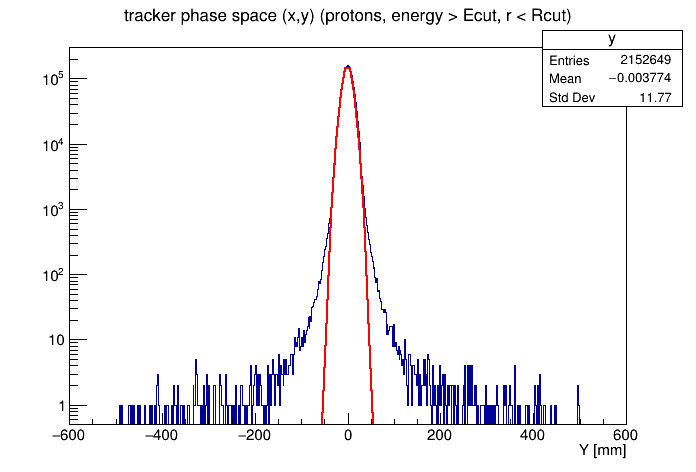

In [32]:
c1 = ROOT.TCanvas()
projY.Draw()
f1_res.Draw('same')
c1.SetLogy()
c1.Draw()

In [36]:
r=0.1
#f2 = ROOT.TF1('f2','[0] * exp(-x*x/(2*[1]*[1])) + [2] * exp(-x*x/(2*[3]*[3])) + [4] * exp(-x*x/(2*[5]*[5])) + [6] * exp(-x*x/(2*[7]*[7]))',-xmax,xmax)
f2 = ROOT.TF1('f2','[0] * exp(-x*x/(2*[1]*[1])) + [2] * exp(-x*x/(2*[3]*[3])) + [4] * exp(-x*x/(2*[5]*[5]))',-xmax,xmax)
#f2 = ROOT.TF1('f2','[0] * exp(-x*x/(2*[1]*[1])) + [2] * exp(-x*x/(2*[3]*[3]))',-xmax,xmax)
#f2 = ROOT.TF1('f2','[0] * exp(-x*x/(2*[1]*[1]))',-xmax,xmax)


print(type(r))
f2.SetParameters(p0*(1-r),p2*2,p0*r,20,p0*(1-r*r),p2*5)#,p0*(1-r*r*r),p2*10)

print(f1.GetParameters(),f2.GetParameter(0), f2.GetParameter(1),p2)

<class 'float'>
<cppyy.LowLevelView object at 0x7f68641508f0> 142629.31629324268 21.56997709023961 10.784988545119806


In [14]:
#c1 = ROOT.TCanvas()
#projY.Draw()
#f2.SetLineColor(ROOT.kGreen)
#f2.Draw('same')
#c1.SetLogy()
#projY.GetXaxis().SetRangeUser(-400,400)
#c1.Draw()

In [37]:
f2.SetParLimits(0,p0*0.5,p0*5)
#f2.SetParLimits(2,0,p0*0.5)
y1=3
y2=30
f2.SetParLimits(3,p2*1.01,p2*y1)
f2.SetParLimits(5,p2*(y1+.01),p2*y2)
#f2.SetParLimits(7,p2*(y2+.01),p2*y2*10)
f2_res = projY.Fit(f2, 'RS')
#print(f1_res)
#print(f2_res)

 FCN=531.93 FROM MIGRAD    STATUS=CONVERGED    1316 CALLS        1317 TOTAL
                     EDM=1.99929e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.6 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.55404e+05   4.42711e+02  -1.39062e-06  -8.40072e-01
   2  p1           1.02897e+01   1.80074e-02   1.15835e-05   1.89526e-02
   3  p2           6.23572e+03   4.61891e+02  -2.31255e-01   6.03248e-06
   4  p3           1.81595e+01   3.14840e-01   1.55693e-05   1.71897e-02
   5  p4           1.01439e+02   1.48649e+01   6.33515e-04   1.77060e-04
   6  p5           4.77589e+01   1.88539e+00  -4.11229e-06   8.96679e-02



****************************************
Minimizer is Minuit / Migrad
Chi2                      =       531.93
NDf                       =          326
Edm                       =  1.99929e-07
NCalls                    =         1317
p0                        =       155404   +/-   442.711      	 (limited)
p1                        =      10.2897   +/-   0.0180074   
p2                        =      6235.72   +/-   461.891     
p3                        =      18.1595   +/-   0.31484      	 (limited)
p4                        =      101.439   +/-   14.8649     
p5                        =      47.7589   +/-   1.88539      	 (limited)



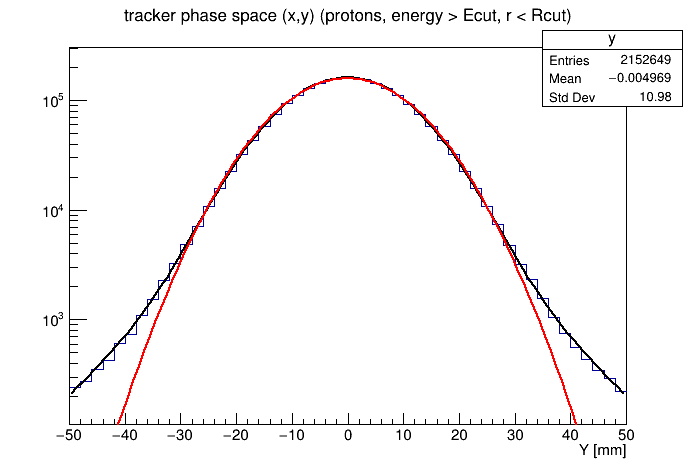

In [46]:
cy1 = ROOT.TCanvas()
projY.Draw()
f2.SetLineColor(ROOT.kBlack)
f2.Draw('same')
f1.SetLineColor(ROOT.kRed)
f1.Draw('same')
projY.GetXaxis().SetRangeUser(-50,50)
cy1.SetLogy()
cy1.Draw()
#print(f1_res)
print(f2_res)

In [44]:
print(projY.Integral(-xmax,xmax),f2.Integral(-xmax,xmax),f1.Integral(-xmax,xmax))
print(   f2.Integral(-xmax,xmax)-f1.Integral(-xmax,xmax))
print(   f2.Integral(-xmax,xmax)-projY.Integral(-xmax,xmax))

1077036.0 4304235.83071231 4284260.929155616
19974.90155669395
3227199.83071231


In [18]:
#cc2 = ROOT.TCanvas()
#targ.Draw()
#cc2.Draw()

X Axis

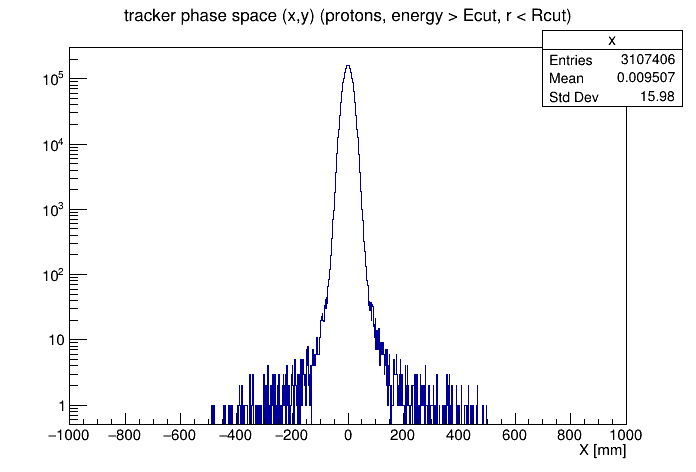

In [19]:
cc2 = ROOT.TCanvas()
#targX=targ.Clone()
projX = targ.ProjectionX("x",targ.GetYaxis().FindBin(-2),targ.GetYaxis().FindBin(2))
projX.Draw()
cc2.Draw()
cc2.SetLogy()

In [20]:
xmax=500
fx1 = ROOT.TF1('fx1','gaus',-xmax,xmax)
fx1_res = projX.Fit(fx1, 'RS')
print(fx1_res)
px0 = fx1.GetParameter(0)
px1 = fx1.GetParameter(1)
px2 = fx1.GetParameter(2)


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      3561.42
NDf                       =          330
Edm                       =   2.1294e-07
NCalls                    =           64
Constant                  =       159056   +/-   112.418     
Mean                      =   0.00670935   +/-   0.00883772  
Sigma                     =        15.57   +/-   0.0065569    	 (limited)

 FCN=3561.42 FROM MIGRAD    STATUS=CONVERGED      63 CALLS          64 TOTAL
                     EDM=2.1294e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.59056e+05   1.12418e+02   2.63082e+00   5.79810e-06
   2  Mean         6.70935e-03   8.83772e-03   2.57561e-04  -2.28650e-02
   3  Sigma        1.55700e+01   6.55690e-03   3.23865e-06   4.00902e-01


In [21]:
r=0.1
xmax=500
#f2 = ROOT.TF1('f2','[0] * exp(-x*x/(2*[1]*[1])) + [2] * exp(-x*x/(2*[3]*[3])) + [4] * exp(-x*x/(2*[5]*[5]))',-xmax,xmax) # + [6] * exp(-x*x/(2*[7]*[7]))
fx2 = ROOT.TF1('fx2','[0] * exp(-x*x/(2*[1]*[1])) + [2] * exp(-x*x/(2*[3]*[3]))',-xmax,xmax) # + [4] * exp(-x*x/(2*[5]*[5])) + [6] * exp(-x*x/(2*[7]*[7]))

print(type(r))
fx2.SetParameters(px0*(1-r),px2,px0*r,20,px0*(1-r*r),px2)#,px0*(1-r*r*r),px2*10)

print(fx1.GetParameter(0),fx2.GetParameter(0), fx2.GetParameter(1),px0,px1,px2)

<class 'float'>
159056.04407954967 143150.4396715947 15.570046717592556 159056.04407954967 0.0067093457619991186 15.570046717592556


In [22]:
fx2.SetParLimits(0,px0*0.5,px0*2)
fx2.SetParLimits(2,0.1,px0*0.5)
x1=3
x2=20
fx2.SetParLimits(1,px2*0.1,px2*5)
fx2.SetParLimits(3,px2*1.01,px2*x1)
fx2.SetParLimits(4,0.1,px0)
fx2.SetParLimits(5,px2*(x1+0.1),px2*x2)
#f2.SetParLimits(6,0.1,p0)
#f2.SetParLimits(7,p2*(x2+0.1),p2*x2*20)
fx2_res = projX.Fit(fx2, 'RS')
#print(f1_res)
#print(f2_res)

 FCN=785.84 FROM MIGRAD    STATUS=CONVERGED     300 CALLS         301 TOTAL
                     EDM=7.34712e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.59084e+05   1.23016e+02   1.11195e-05   3.04093e-01
   2  p1           1.53920e+01   1.12125e-02   2.46848e-06  -5.00973e-01
   3  p2           9.52949e+02   8.63717e+01   2.42015e-05  -4.06710e-02
   4  p3           3.15834e+01   5.90897e-01   1.06212e-04  -9.45323e-03



****************************************
Minimizer is Minuit / Migrad
Chi2                      =      3561.42
NDf                       =          330
Edm                       =   2.1294e-07
NCalls                    =           64
Constant                  =       159056   +/-   112.418     
Mean                      =   0.00670935   +/-   0.00883772  
Sigma                     =        15.57   +/-   0.0065569    	 (limited)


****************************************
Minimizer is Minuit / Migrad
Chi2                      =       785.84
NDf                       =          329
Edm                       =  7.34712e-08
NCalls                    =          301
p0                        =       159084   +/-   123.016      	 (limited)
p1                        =       15.392   +/-   0.0112125    	 (limited)
p2                        =      952.949   +/-   86.3717      	 (limited)
p3                        =      31.5834   +/-   0.590897     	 (limited)



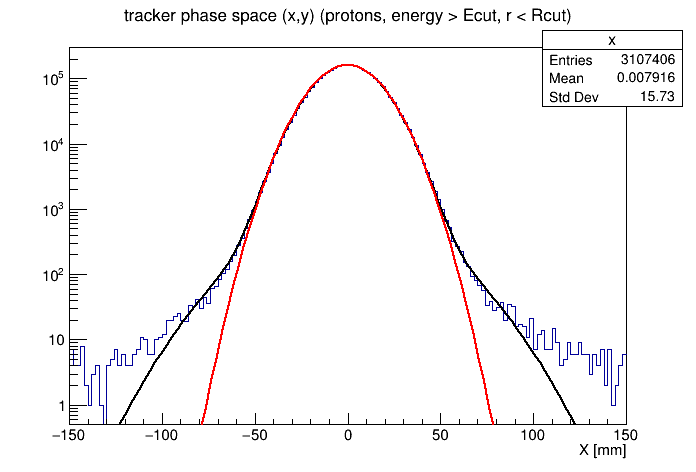

In [23]:
cx2 = ROOT.TCanvas()
projX.Draw()
fx2.SetLineColor(ROOT.kBlack)
fx2.Draw('same')
fx1.Draw('same')
projX.GetXaxis().SetRangeUser(-150,150)
cx2.SetLogy()
cx2.Draw()
print(fx1_res)
print(fx2_res)

In [24]:
print(projX.Integral(-xmax,xmax),fx2.Integral(-xmax,xmax))
print(projX.Integral(-xmax,xmax)-fx2.Integral(-xmax,xmax))

1553661.0 6213241.108775375
-4659580.108775375


In [25]:
1/(f2.GetParameter(2)*ROOT.sqrt(6.28))

6.399320511424216e-05

In [26]:
Gdata = projY.GetIntegral()
#c1 = ROOT.TCanvas()

#c1.Draw()


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      10518.5
NDf                       =          329
Edm                       =  8.04412e-09
NCalls                    =           67
Constant                  =       158477   +/-   137.493     
Mean                      =  -0.00507183   +/-   0.0073688   
Sigma                     =       10.785   +/-   0.00576596   	 (limited)


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      383.906
NDf                       =          327
Edm                       =  5.84408e-07
NCalls                    =         1188
p0                        =       158784   +/-   144.676      	 (limited)
p1                        =      15.3561   +/-   0.0125732   
p2                        =      1384.61   +/-   129.08      
p3                        =       29.016   +/-   0.5172       	 (limited)
p4                        =      3.10569   +/-   0.341924  

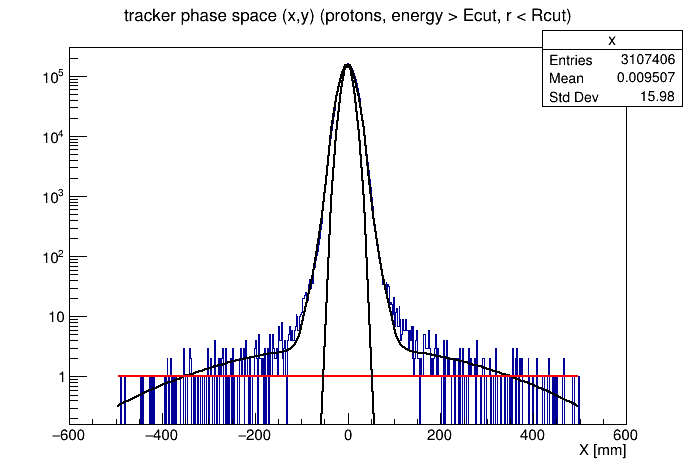

In [27]:
projX = targ.ProjectionX("x",targ.GetYaxis().FindBin(-2),targ.GetYaxis().FindBin(2))
f3 = ROOT.TF1("f3","1/ pow(x,[0])",-xmax,xmax)
f3_res = projX.Fit(f2, 'RS')
c1 = ROOT.TCanvas()
projX.Draw()
f1.SetLineColor(ROOT.kBlack)
f3.Draw('same')
f1.Draw('same')
projX.GetXaxis().SetRangeUser(-600,600)
c1.SetLogy()
c1.Draw()
print(f1_res)
print(f3_res)